# Simulating the phase pupil via Fourier Transforms

In [51]:
# Add local scripts to module search path
import sys
import os

sys.path.append(os.path.realpath('../toliman-proper'))

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import numpy as np
# from spirals import binarized_ringed_flipped

In [52]:
# def binarized_ringed_650_scaled(r, phi, r_max=20., r_min=0., r_split=15):
#     phase = 650.*1e-9*0.5 # Has units of nm
#     return binarized_ringed_flipped(r, phi, phase, r_max=r_max, r_min=r_min, r_split=r_split)

from math import sin, log10, cos, atan2, hypot

def binarized_ringed_flipped(r, phi, phase, thresh=0., white=0, empty=0., r_max=300., r_min=50., r_split=246.):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    

    s = 0.15/300. # m/internal sampling dist
#     Physical dimensions
    r_max = 300.
    r_max = 10.
    r_min = 50.
    r_min = 0.
    r_split = 6.9 # interface between main sprial and outer rim
#     r_split = 246./30.
    
    black = phase
    v = empty
    r = r/s

    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        if (r>r_split): # Outer rim
            if (c3<thresh):
                if (sin(chi3/2.)<thresh):
                    v=black if (c1*c2*c3>thresh) else white
                else:
                    v=black                
            else:                
                v=black if (c1*c2*c3>thresh) else white
        else: # Main spiral
            v=black if (c1*c2*c3>thresh) else white
    return v


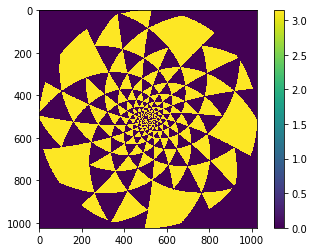

1024.0
CPU times: user 4.46 s, sys: 55.8 ms, total: 4.52 s
Wall time: 4.43 s


In [53]:
%%time

import math

# ngrid = 2048
ngrid = 1024
ratio = 30
diam = 0.3
phase = 650e-9

sampling = diam/(ngrid*ratio) ## Fills the space at value of '6'


c = ngrid/2.
spiral = np.zeros([ngrid, ngrid], dtype = np.complex)

for i in range(ngrid):
    for j in range(ngrid):
        x = i - c
        y = j - c
        phi = math.atan2(y, x)
        r = sampling*math.hypot(x,y)
        spiral[i][j] = binarized_ringed_flipped(r, phi, complex(-1,0),white=complex(1,0))


plt.imshow(np.angle(spiral))
plt.colorbar()
plt.show()

print(np.size(spiral)**0.5)

In [54]:
## Plate scale
f = 77 # mm
Fov = 7200 # arcsec
npix = 2400

p_scale = (206265/f)/(Fov/npix)
# p_scale = 1/f
print(p_scale)

892.9220779220778


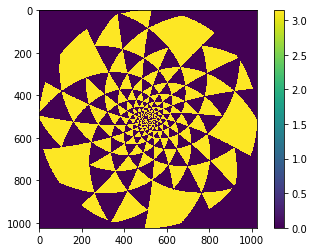

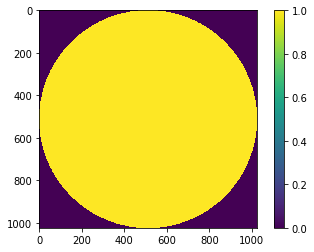

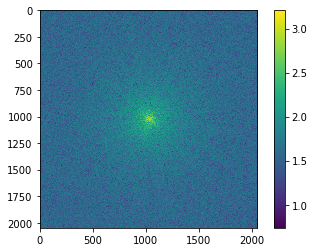

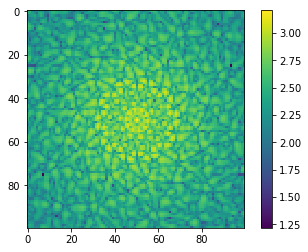

In [55]:
mask = spiral # Spiral is now a complex array
chip_dim = 100
# plate_scale = 1.12e-5 #??
grid_size = int(np.size(spiral)**0.5)
mask_size = 20e-3 # Diameter


# wavels = np.linspace(400e-9,700e-9,5) # 400-700nm
wavels = [500]


# spatial_freq = wavels[0]/mask_size
# print(grid_size*spatial_freq/p_scale)


im_out = np.zeros((chip_dim,chip_dim))

plt.imshow(np.angle(mask))
plt.colorbar()
plt.show()

plt.imshow(np.abs(mask))
plt.colorbar()
plt.show()

for wavel in wavels:
    spatial_freq = wavel/mask_size
#     array_size = int(grid_size*spatial_freq/plate_scale)
#     complex_array = np.array(np.zeros((array_size,array_size)),dtype=complex)
    complex_array = np.array(np.zeros((2*grid_size,2*grid_size)),dtype=complex)
    complex_array[0:grid_size,0:grid_size] = mask
    
    im = np.abs(np.fft.fft2(complex_array))**2
    im = np.fft.fftshift(im)
    
    for y in range(chip_dim):
        for x in range(chip_dim):
#             im_out[y][x] += im[int((array_size-chip_dim)/2) + y][int((array_size-chip_dim)/2) + x]
            im_out[y][x] += im[int((2*grid_size-chip_dim)/2) + y][int((2*grid_size-chip_dim)/2) + x]
    
plt.imshow(im**0.05)
plt.colorbar()
plt.show()

plt.imshow(im_out**0.05)
plt.colorbar()
plt.show()  

In [56]:

mask = spiral                       # Phase mask
grid_size = mask.shape[1]           # Size if mask in pixels
chip_dim = 64                       # Size of chip in pixels - real chip is 3280 x 2464
mask_size = 20.e-3                  # Size of mask, Units assumed to be m
wavels = [470e-9,600e-9]            # Wavelength of light, Units assumed to be m
                                    # this is (approx) for the Green Bayer filter.
                                    # Blue is 400-500 and Red is 570-650 (eyeball from plots)

foc_length=77.e-3                   # focal length of lens (m)
pix_size = 1.12e-6                  # pixel size (m)

plate_scale = pix_size / foc_length # In radians per pixel

wavelv = np.linspace(wavels[0],wavels[1],10) # vector of Wavelength of light, Units assumed to be m

im_out = np.zeros((chip_dim,chip_dim))
for wavel in wavelv:
    print(wavel)
    spatial_freq = wavel/mask_size
    array_size = int(grid_size*spatial_freq/plate_scale)
    complex_array = np.array(np.zeros((array_size,array_size)),dtype=complex)

    complex_array[0:grid_size,0:grid_size] = mask

    im = np.fft.fftshift(np.abs(np.fft.fft2(complex_array))**2)

    for y in range(chip_dim):
        for x in range(chip_dim):
            im_out[y][x] += im[int((array_size-chip_dim)/2) + y][int((array_size-chip_dim)/2) + x]

plt.imshow(im**0.05)
plt.colorbar()
plt.title("Fourier Transform")
plt.show()

# Now make up Bayer pattern to down-sample the image
bayer_green = np.remainder((np.arange(chip_dim**2))+np.arange(chip_dim**2)/chip_dim,2)
bayer_green = bayer_green.reshape(chip_dim,chip_dim)

bayer_blue = np.remainder((np.arange(chip_dim**2))+1+np.arange(chip_dim**2)/chip_dim,4)/3
bayer_blue = bayer_blue.reshape(chip_dim,chip_dim)

bayer_red = np.remainder((np.arange(chip_dim**2))-1+np.arange(chip_dim**2)/chip_dim,4)/3
bayer_red = bayer_red.reshape(chip_dim,chip_dim)



im_red = bayer_red*im_out
im_green = bayer_green*im_out
im_blue = bayer_blue*im_out

plt.figure(1)
plt.imshow(im_out**0.05)
plt.colorbar()
plt.title("Image seen on chip")

plt.figure(2)
im_final = im_green + im_blue + im_red
plt.imshow(im_final**0.05)
plt.colorbar()
plt.title("Image final")
plt.show()
